# Feature Descriptors & Feature Matching (SIFT / ORB / SURF)

This notebook demonstrates:

- Keypoint detection + descriptor extraction  
- Feature matching using **BFMatcher + KNN + Lowe’s Ratio Test**  
- Match visualization using **drawMatches**  
- (Optional) Homography estimation using **RANSAC**

> Notes  
> - **SIFT** is available in standard OpenCV builds.  
> - **ORB** is free and fast (binary descriptors → Hamming distance).  
> - **SURF** is often unavailable in standard `opencv-python` installs (non-free).  


In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version:", cv2.__version__)


OpenCV version: 4.12.0


## 1) Provide Input Images

Use two images with overlap (same object/scene from different angles).


In [8]:
img1_path = "cat1.jpg"
img2_path = "cat2.jpg"

# Choose algorithm: "ORB" (recommended), "SIFT", "SURF"
ALGORITHM = "ORB"


## 2) Utility: Load Images

In [9]:
def load_image_pair(img1_path, img2_path):
    """Load two images (BGR) and their grayscale versions."""
    img1_color = cv2.imread(img1_path)
    img2_color = cv2.imread(img2_path)

    if img1_color is None:
        raise FileNotFoundError(f"Cannot load image 1: {img1_path}")
    if img2_color is None:
        raise FileNotFoundError(f"Cannot load image 2: {img2_path}")

    img1_gray = cv2.cvtColor(img1_color, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2_color, cv2.COLOR_BGR2GRAY)

    return img1_color, img1_gray, img2_color, img2_gray


img1_color, img1_gray, img2_color, img2_gray = load_image_pair(img1_path, img2_path)

print("Image 1 shape:", img1_gray.shape)
print("Image 2 shape:", img2_gray.shape)


Image 1 shape: (679, 1024)
Image 2 shape: (851, 1280)


## 3) Helper: Display Images

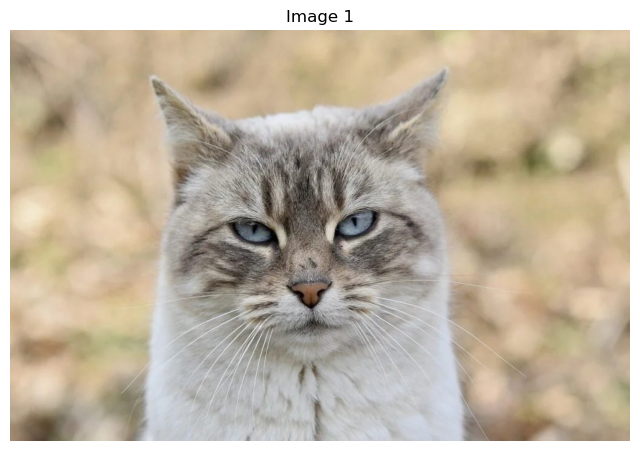

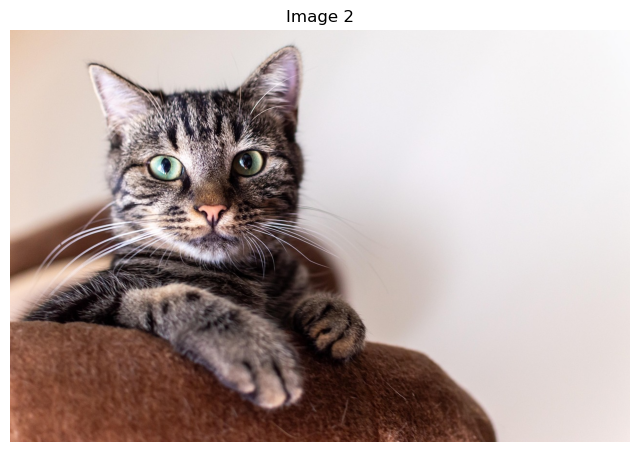

In [10]:
def show_bgr(img_bgr, title="", figsize=(8, 6)):
    """Matplotlib expects RGB, OpenCV loads BGR."""
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


show_bgr(img1_color, "Image 1")
show_bgr(img2_color, "Image 2")


## 4) Feature Extraction (SIFT / ORB / SURF)

Each function returns:

- `keypoints`: list of OpenCV KeyPoint objects  
- `descriptors`: descriptor matrix (float for SIFT/SURF, binary for ORB)


In [11]:
def detect_and_compute_sift(gray_img):
    """SIFT: 128-d float descriptors, robust but heavier."""
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray_img, None)
    return kp, des


def detect_and_compute_orb(gray_img, nfeatures=2500):
    """ORB: binary descriptors, very fast (Hamming distance)."""
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp, des = orb.detectAndCompute(gray_img, None)
    return kp, des


def detect_and_compute_surf(gray_img):
    """SURF: often unavailable in standard OpenCV installs."""
    try:
        surf = cv2.xfeatures2d.SURF_create()
        kp, des = surf.detectAndCompute(gray_img, None)
        return kp, des
    except AttributeError:
        print("[INFO] SURF is not available in this OpenCV build.")
        return [], None
    except cv2.error as e:
        print("[INFO] SURF error:", e)
        return [], None


## 5) Detect Keypoints + Compute Descriptors

In [12]:
algo = ALGORITHM.upper()

if algo == "SIFT":
    kp1, des1 = detect_and_compute_sift(img1_gray)
    kp2, des2 = detect_and_compute_sift(img2_gray)

elif algo == "ORB":
    kp1, des1 = detect_and_compute_orb(img1_gray, nfeatures=2500)
    kp2, des2 = detect_and_compute_orb(img2_gray, nfeatures=2500)

elif algo == "SURF":
    kp1, des1 = detect_and_compute_surf(img1_gray)
    kp2, des2 = detect_and_compute_surf(img2_gray)

else:
    raise ValueError("ALGORITHM must be one of: ORB / SIFT / SURF")

print(f"[{algo}] Keypoints in Image 1:", len(kp1))
print(f"[{algo}] Keypoints in Image 2:", len(kp2))
print(f"[{algo}] Descriptor shapes:", None if des1 is None else des1.shape, "|", None if des2 is None else des2.shape)


[ORB] Keypoints in Image 1: 2500
[ORB] Keypoints in Image 2: 2500
[ORB] Descriptor shapes: (2500, 32) | (2500, 32)


## 6) Visualize Keypoints (Scale + Orientation)

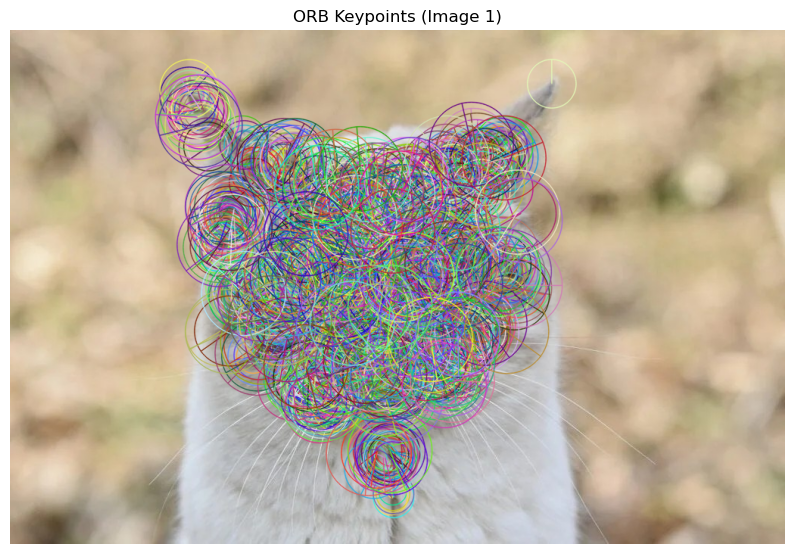

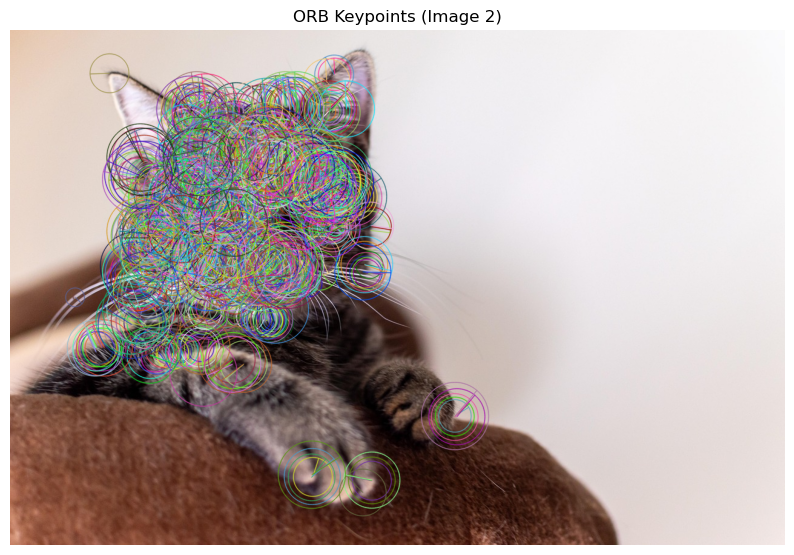

In [13]:
def draw_keypoints(img_color, keypoints, title="Keypoints", figsize=(10, 7)):
    out = cv2.drawKeypoints(
        img_color,
        keypoints,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


draw_keypoints(img1_color, kp1, f"{algo} Keypoints (Image 1)")
draw_keypoints(img2_color, kp2, f"{algo} Keypoints (Image 2)")


## 7) Feature Matching (BFMatcher + KNN + Lowe’s Ratio Test)

- **SIFT/SURF** → L2 distance  
- **ORB** → Hamming distance  

We use:
- `knnMatch(k=2)`  
- Lowe’s ratio test to remove ambiguous matches


In [14]:
def match_features_knn_ratio(des1, des2, method="ORB", ratio=0.75):
    if des1 is None or des2 is None:
        return []

    method = method.upper()

    if method in ["SIFT", "SURF"]:
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    elif method == "ORB":
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
    else:
        raise ValueError("method must be SIFT / SURF / ORB")

    knn = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in knn:
        if m.distance < ratio * n.distance:
            good.append(m)

    return good


matches = match_features_knn_ratio(des1, des2, method=algo, ratio=0.75)
print(f"[{algo}] Matches after ratio test:", len(matches))


[ORB] Matches after ratio test: 27


## 8) Visualize Matches (drawMatches)

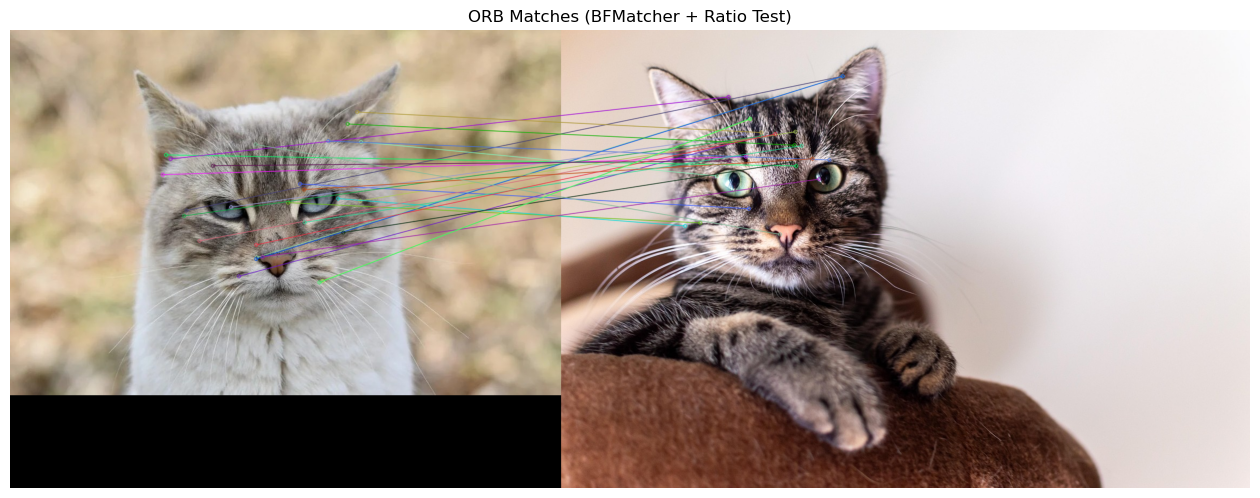

In [15]:
def show_matches(img1_color, kp1, img2_color, kp2, matches, title="", max_draw=60, figsize=(16, 7)):
    matches = sorted(matches, key=lambda x: x.distance)

    out = cv2.drawMatches(
        img1_color, kp1,
        img2_color, kp2,
        matches[:max_draw],
        None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=figsize)
    plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()


show_matches(
    img1_color, kp1,
    img2_color, kp2,
    matches,
    title=f"{algo} Matches (BFMatcher + Ratio Test)",
    max_draw=80
)


## 9) (Optional) Homography with RANSAC

This step is commonly used in:
- panorama stitching  
- image registration  
- object localization  

It removes outlier matches and keeps only geometrically consistent correspondences.


In [16]:
def estimate_homography_ransac(kp1, kp2, matches, ransac_thresh=5.0):
    if len(matches) < 4:
        return None, None

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
    return H, mask


H, mask = estimate_homography_ransac(kp1, kp2, matches)

if H is None or mask is None:
    print("Homography not estimated (need at least 4 matches).")
else:
    inliers = int(mask.sum())
    print(f"RANSAC inliers: {inliers}/{len(matches)}")
    print("Homography matrix:\n", H)


RANSAC inliers: 7/27
Homography matrix:
 [[-1.08299941e+00  5.78029355e-01  3.73930250e+02]
 [-5.76079204e-01  2.98394393e-01  2.02279157e+02]
 [-2.90666543e-03  1.56452550e-03  1.00000000e+00]]


## 10) (Optional) Visualize Inlier Matches Only

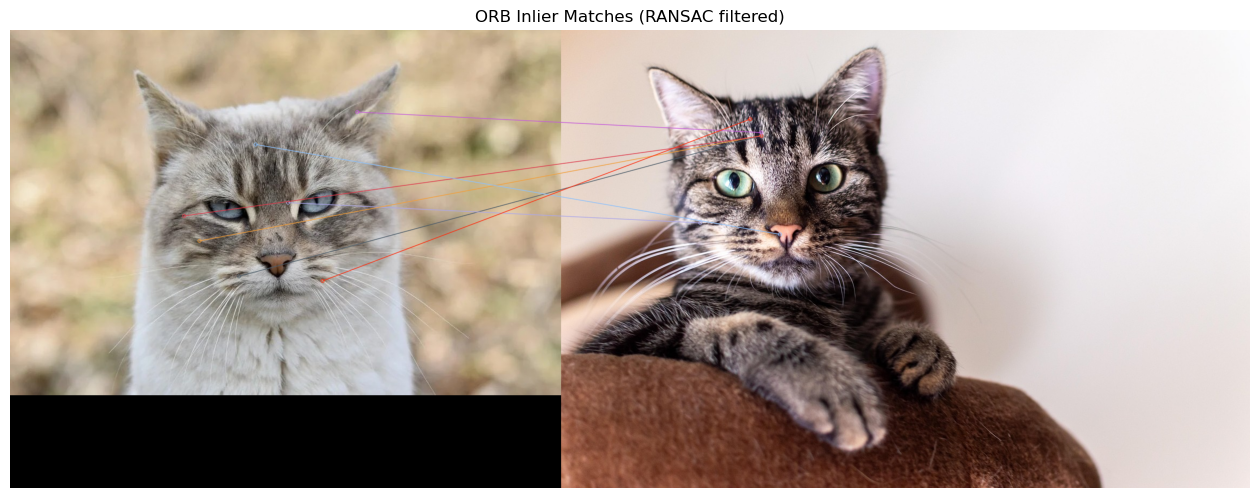

In [17]:
if H is not None and mask is not None:
    inlier_matches = [m for m, keep in zip(matches, mask.ravel()) if keep == 1]

    show_matches(
        img1_color, kp1,
        img2_color, kp2,
        inlier_matches,
        title=f"{algo} Inlier Matches (RANSAC filtered)",
        max_draw=120
    )
else:
    print("Skipping inlier visualization.")


## 12) Conclusion

In this lab, we implemented a complete **feature-based image matching pipeline** using classical computer vision techniques.

- We extracted **keypoints** and **descriptors** using **SIFT / ORB / SURF**.
- We matched descriptors using **Brute-Force Matching (BFMatcher)**.
- We improved match quality using **KNN matching** with **Lowe’s Ratio Test** to reduce ambiguous correspondences.
- We visualized the final correspondences using **drawMatches**, which helps verify whether the detected matches are meaningful.
- Finally, we optionally applied **RANSAC-based homography estimation** to filter out outliers and keep only geometrically consistent matches.

Overall, this experiment demonstrates how local feature descriptors enable robust matching between two images even under changes in viewpoint, scale, and illumination. This concept is widely used in real-world applications such as **panorama stitching**, **image registration**, **object recognition**, and **SLAM**.
